In [ ]:
from __future__ import print_function

import os
import pandas as pd
#import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import time
import pdb
import pickle
import random
import datetime 

import seaborn as sns 

import prim

import warnings; warnings.simplefilter('ignore')

In [ ]:
%matplotlib notebook

# Data loading

In [3]:
data17_tg=pd.read_excel('EMIVASA_validationOutput_update2020.xlsx',sheet_name='sH2O users') # 2017 data - treatment group
data17_cg=pd.read_excel('EMIVASA_validationOutput_update2020.xlsx',sheet_name='Control group') # 2017 data - control group
data_tg_hour = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Horaria',converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group hourly frequency
data_tg_day = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Diaria', converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group daily frequency
data_tg_visual = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_visual',converters={'ENTORNO': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group visual reading

data19=pd.read_excel("Datos consumo hasta febrero 2019.xls") # 2019 data

In [5]:
# Merging user ID
data_tg_hour.keys()
data_tg_hour['User_ID']='AGM' + (data_tg_hour.NIA.astype(str))
data_tg_hour['User_ID']=data_tg_hour.User_ID.str.cat(data_tg_hour.SUBNIA.astype(str))
data_tg_day['User_ID']='AGM' + (data_tg_day.NIA.astype(str))
data_tg_day['User_ID']=data_tg_day.User_ID.str.cat(data_tg_day.SUBNIA.astype(str))
data_tg_visual['User_ID']='AGM' + (data_tg_visual.NIA.astype(str))
data_tg_visual['User_ID']=data_tg_visual.User_ID.str.cat(data_tg_visual.SUBNIA.astype(str))

# Data processing

In [6]:
# Finding user ID of SmartH2O users

# Treatment/control group ID in 2017 dataset
userID17_tg = data17_tg.User_ID
userID17_cg = data17_cg.User_ID

# Treatment/control group ID in 2019 dataset
userID19 = np.unique(data19['ID'])
userID19_tg = np.isin(userID19, userID17_tg) # treatment group
userID19_cg = np.isin(userID19, userID17_cg) # control group

userID19_tg = userID19[userID19_tg==True]
userID19_cg = userID19[userID19_cg==True]

## Storing all data for treatment group (SmartH2O users)

In [7]:
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August
allData_tg = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_tg:

    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser
    
    #print(data19[currUserCondition])
    #pdb.set_trace()

    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170601
    dateConditionEnd18 = data19['FECHA']<=20180228
    dateConditionZero17= data19['FECHA']<20170601 # This is used to evaluate the number of days considered in the first reading
    
    dateConditionStart18 = data19['FECHA']>=20180601
    dateConditionEnd19 = data19['FECHA']<=20190228
    dateConditionZero18= data19['FECHA']<20180601 # This is used to evaluate the number of days considered in the first reading

    # Start and end date for summer peak:
    summerConditionStart17 = data19['FECHA']>=20170701 # July
    summerConditionEnd17 = data19['FECHA']<=20170831 # August
    summerConditionZero17= data19['FECHA']<20170701 # This is used to evaluate the number of days considered in the first reading

    summerConditionStart18 = data19['FECHA']>=20180701 # July
    summerConditionEnd18 = data19['FECHA']<=20180831 # August
    summerConditionZero18= data19['FECHA']<20180701 # This is used to evaluate the number of days considered in the first reading

    # ::: Evaluating average consumption
    tg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    tg_data1718_sp = data19[currUserCondition & summerConditionStart17 & summerConditionEnd17] # Summer peak 17
    dateZero1718 = data19[currUserCondition & dateConditionZero17]
    dateZero1718_sp = data19[currUserCondition & summerConditionZero17]
  
    tg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    tg_data1819_sp = data19[currUserCondition & summerConditionStart18 & summerConditionEnd18] # Summer peak 18
    dateZero1819 = data19[currUserCondition & dateConditionZero18]
    dateZero1819_sp = data19[currUserCondition & summerConditionZero18]
    
    # Number of days for each period
    #
    # Observation period 17-18
    startD = datetime.datetime.strptime(str(tg_data1718.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
    if dateZero1718['FECHA'].empty==False:
        zeroD = datetime.datetime.strptime(str(dateZero1718.iloc[-1]['FECHA']),'%Y%m%d') 
        if startD!=zeroD:
            nDays1718 = (endD-startD).days + (startD-zeroD).days
    else:
        nDays1718 = (endD-startD).days + startD.day

    #
    # Observation period 18-19
    startD = datetime.datetime.strptime(str(tg_data1819.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
    if dateZero1819['FECHA'].empty==False:
        zeroD = datetime.datetime.strptime(str(dateZero1819.iloc[-1]['FECHA']),'%Y%m%d') 
        if startD!=zeroD:
            nDays1819 = (endD-startD).days + (startD-zeroD).days
    else:
        nDays1819 = (endD-startD).days + startD.day
    #
    # Summer peak 17
    startD = datetime.datetime.strptime(str(tg_data1718_sp.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1718_sp.iloc[-1]['FECHA']),'%Y%m%d') 
    if dateZero1718_sp['FECHA'].empty==False:
        zeroD = datetime.datetime.strptime(str(dateZero1718_sp.iloc[-1]['FECHA']),'%Y%m%d') 
        if startD!=zeroD:
            nDays1718_sp = (endD-startD).days + (startD-zeroD).days
    else:
        nDays1718_sp = (endD-startD).days + startD.day
    #
    # Summer peak 18
    startD = datetime.datetime.strptime(str(tg_data1819_sp.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(tg_data1819_sp.iloc[-1]['FECHA']),'%Y%m%d') 
    if dateZero1819_sp['FECHA'].empty==False:
        zeroD = datetime.datetime.strptime(str(dateZero1819_sp.iloc[-1]['FECHA']),'%Y%m%d') 
        if startD!=zeroD:
            nDays1819_sp = (endD-startD).days + (startD-zeroD).days
    else:
        nDays1819_sp = (endD-startD).days + startD.day
    
    # Average consumption values
    tg_data1718_avg = sum(tg_data1718['CONSUMO'])/nDays1718
    tg_data1819_avg = sum(tg_data1819['CONSUMO'])/nDays1819
    tg_data1718_avg_sp = sum(tg_data1718_sp['CONSUMO'])/nDays1718_sp
    tg_data1819_avg_sp = sum(tg_data1819_sp['CONSUMO'])/nDays1819_sp
    
    # Data frequency for meter reading: hourly/daily/visual. Data about the metere reading frequency only refer to the period 2017-18
    freq=[]
    if (np.isin(currUser, np.unique(data_tg_hour['User_ID']))):
        freq = 'hourly readings'
    elif (np.isin(currUser, np.unique(data_tg_day['User_ID']))):
        freq = 'daily readings'
    elif (np.isin(currUser, np.unique(data_tg_visual['User_ID']))):
        freq = 'visual readings'
        print('done')
    else:
        freq = np.nan

    # Conditions for outlier removal
    emptyHouseCondition = tg_data1718['CONSUMO'].empty or tg_data1819['CONSUMO'].empty # Homes with no entries
    zeroRedingsPercCondition = np.percentile(tg_data1718['CONSUMO'],90) == 0 or np.percentile(tg_data1819['CONSUMO'],90) == 0
    lowOutlierCondition = sum(tg_data1718['CONSUMO']) < 1.5 or sum(tg_data1819['CONSUMO']) < 1.5
    highOutlierCondition = tg_data1718_avg > 1 or tg_data1819_avg > 1

    # All data to save           
    if emptyHouseCondition or zeroRedingsPercCondition or lowOutlierCondition or highOutlierCondition:
        continue
    else:
        tempDf = pd.DataFrame({"User_ID":currUser, 
                               "avg_baseline":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_baseline'],
                               "avg_1617":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_observation'],
                               "avg_1718":tg_data1718_avg,
                               "avg_1819":tg_data1819_avg,
                               "avg_sp_17":tg_data1718_avg_sp,
                               "avg_sp_18":tg_data1819_avg_sp,
                               "tg": 1,
                               "freq": freq
                              }) 
        allData_tg=allData_tg.append(tempDf,ignore_index=True)
    #allData_tg.to_csv('allData_tg.csv',index=False)
    

In [8]:
len(allData_tg)

223

## Storing all data for control group

In [9]:
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August

allData_cg = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_cg:
    #print(currUser)
    #print(data19[currUserCondition])
    #pdb.set_trace()
    
    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser

    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170601
    dateConditionEnd18 = data19['FECHA']<=20180228
    dateConditionZero17= data19['FECHA']<20170601 # This is used to evaluate the number of days considered in the first reading
    
    dateConditionStart18 = data19['FECHA']>=20180601
    dateConditionEnd19 = data19['FECHA']<=20190228
    dateConditionZero18= data19['FECHA']<20180601 # This is used to evaluate the number of days considered in the first reading

    # Start and end date for summer peak:
    summerConditionStart17 = data19['FECHA']>=20170701 # July
    summerConditionEnd17 = data19['FECHA']<=20170831 # August
    summerConditionZero17= data19['FECHA']<20170701 # This is used to evaluate the number of days considered in the first reading

    summerConditionStart18 = data19['FECHA']>=20180701 # July
    summerConditionEnd18 = data19['FECHA']<=20180831 # August
    summerConditionZero18= data19['FECHA']<20180701 # This is used to evaluate the number of days considered in the first reading

    # ::: Evaluating average consumption
    cg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    cg_data1718_sp = data19[currUserCondition & summerConditionStart17 & summerConditionEnd17] # Summer peak 17
    dateZero1718 = data19[currUserCondition & dateConditionZero17]
    dateZero1718_sp = data19[currUserCondition & summerConditionZero17]
  
    cg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    cg_data1819_sp = data19[currUserCondition & summerConditionStart18 & summerConditionEnd18] # Summer peak 18
    dateZero1819 = data19[currUserCondition & dateConditionZero18]
    dateZero1819_sp = data19[currUserCondition & summerConditionZero18]
    
    # Number of days for each period
    #
    # Observation period 17-18
    startD = datetime.datetime.strptime(str(cg_data1718.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(cg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
    if dateZero1718['FECHA'].empty==False:
        zeroD = datetime.datetime.strptime(str(dateZero1718.iloc[-1]['FECHA']),'%Y%m%d') 
        if startD!=zeroD:
            nDays1718 = (endD-startD).days + (startD-zeroD).days
    else:
        nDays1718 = (endD-startD).days + startD.day

    #
    # Observation period 18-19
    startD = datetime.datetime.strptime(str(cg_data1819.iloc[0]['FECHA']),'%Y%m%d')
    endD = datetime.datetime.strptime(str(cg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
    if dateZero1819['FECHA'].empty==False:
        zeroD = datetime.datetime.strptime(str(dateZero1819.iloc[-1]['FECHA']),'%Y%m%d') 
        if startD!=zeroD:
            nDays1819 = (endD-startD).days + (startD-zeroD).days
    else:
        nDays1819 = (endD-startD).days + startD.day
    #
    # Summer peak 17
    if (cg_data1718_sp.empty == False):
        startD = datetime.datetime.strptime(str(cg_data1718_sp.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1718_sp.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1718_sp['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1718_sp.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1718_sp = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1718_sp = (endD-startD).days + startD.day
    #
    # Summer peak 18
    if (cg_data1819_sp.empty == False):    
        startD = datetime.datetime.strptime(str(cg_data1819_sp.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1819_sp.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1819_sp['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1819_sp.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1819_sp = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1819_sp = (endD-startD).days + startD.days
    
    # Average consumption values
    cg_data1718_avg = sum(cg_data1718['CONSUMO'])/nDays1718
    cg_data1819_avg = sum(cg_data1819['CONSUMO'])/nDays1819
    if (cg_data1718_sp.empty == False):
        cg_data1718_avg_sp = sum(cg_data1718_sp['CONSUMO'])/nDays1718_sp
    else: 
        cg_data1718_avg_sp = np.nan
    if (cg_data1819_sp.empty == False): 
        cg_data1819_avg_sp = sum(cg_data1819_sp['CONSUMO'])/nDays1819_sp
    else: 
        cg_data1819_avg_sp = np.nan

    # Conditions for outlier removal
    emptyHouseCondition = cg_data1718['CONSUMO'].empty or cg_data1819['CONSUMO'].empty # Homes with no entries
    zeroRedingsPercCondition = np.percentile(cg_data1718['CONSUMO'],90) == 0 or np.percentile(cg_data1819['CONSUMO'],90) == 0
    lowOutlierCondition = sum(cg_data1718['CONSUMO']) < 1.5 or sum(cg_data1819['CONSUMO']) < 1.5
    highOutlierCondition = cg_data1718_avg > 1 or cg_data1819_avg > 1

    # All data to save           
    if emptyHouseCondition or zeroRedingsPercCondition or lowOutlierCondition or highOutlierCondition:
        continue
    else:
        tempDf = pd.DataFrame({"User_ID":currUser, 
                               "avg_baseline":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_baseline'],
                               "avg_1617":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_observation'],
                               "avg_1718":cg_data1718_avg,
                               "avg_1819":cg_data1819_avg,
                               "avg_sp_17":cg_data1718_avg_sp,
                               "avg_sp_18":cg_data1819_avg_sp,
                               "cg": 0
                              }) 
        allData_cg=allData_cg.append(tempDf,ignore_index=True)
    

In [10]:
len(allData_cg)

116

# Summer data

In [11]:
data17_tg=pd.read_excel('EMIVASA_validationOutput_update2020_summer.xlsx',sheet_name='sH2O users') # 2017 data - treatment group summer
data17_cg=pd.read_excel('EMIVASA_validationOutput_update2020_summer.xlsx',sheet_name='Control group') # 2017 data - control group summer
data_tg_hour = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Horaria',converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group hourly frequency
data_tg_day = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_Diaria', converters={'ENTORN': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group daily frequency
data_tg_visual = pd.read_excel('Consumos SH2O_01062017_17022018.xlsx',sheet_name='Lec_visual',converters={'ENTORNO': str,'NIA':str,'SUBNIA':str}) # 2017-18 data - treatment group visual reading

data19=pd.read_excel("Datos consumo hasta febrero 2019.xls") # 2019 data

# Merging user ID
data_tg_hour.keys()
data_tg_hour['User_ID']='AGM' + (data_tg_hour.NIA.astype(str))
data_tg_hour['User_ID']=data_tg_hour.User_ID.str.cat(data_tg_hour.SUBNIA.astype(str))
data_tg_day['User_ID']='AGM' + (data_tg_day.NIA.astype(str))
data_tg_day['User_ID']=data_tg_day.User_ID.str.cat(data_tg_day.SUBNIA.astype(str))
data_tg_visual['User_ID']='AGM' + (data_tg_visual.NIA.astype(str))
data_tg_visual['User_ID']=data_tg_visual.User_ID.str.cat(data_tg_visual.SUBNIA.astype(str))

In [12]:
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August
allData_tg_summer = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_tg:

    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser
    
    #print(data19[currUserCondition])
    #pdb.set_trace()

    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170701
    dateConditionEnd18 = data19['FECHA']<=20170831
    dateConditionZero17= data19['FECHA']<20170701 # This is used to evaluate the number of days considered in the first reading
    
    dateConditionStart18 = data19['FECHA']>=20180701
    dateConditionEnd19 = data19['FECHA']<=20180831
    dateConditionZero18= data19['FECHA']<20180701 # This is used to evaluate the number of days considered in the first reading

    # ::: Evaluating average consumption
    tg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    dateZero1718 = data19[currUserCondition & dateConditionZero17]
  
    tg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    dateZero1819 = data19[currUserCondition & dateConditionZero18]
    
    # Number of days for each period
    #
    # Observation period 17-18
    if (tg_data1718.empty == False):
        startD = datetime.datetime.strptime(str(tg_data1718.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(tg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1718['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1718.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1718 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1718 = (endD-startD).days + startD.day

    #
    # Observation period 18-19
    if (tg_data1819.empty == False):
        startD = datetime.datetime.strptime(str(tg_data1819.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(tg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1819['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1819.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1819 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1819 = (endD-startD).days + startD.day
    #
       
    # Average consumption values
    tg_data1718_avg = sum(tg_data1718['CONSUMO'])/nDays1718
    tg_data1819_avg = sum(tg_data1819['CONSUMO'])/nDays1819
    
    # Data frequency for meter reading: hourly/daily/visual. Data about the metere reading frequency only refer to the period 2017-18
    freq=[]
    if (np.isin(currUser, np.unique(data_tg_hour['User_ID']))):
        freq = 'hourly readings'
    elif (np.isin(currUser, np.unique(data_tg_day['User_ID']))):
        freq = 'daily readings'
    elif (np.isin(currUser, np.unique(data_tg_visual['User_ID']))):
        freq = 'visual readings'
        print('done')
    else:
        freq = np.nan

    # Conditions for outlier removal
    emptyHouseCondition = tg_data1718['CONSUMO'].empty or tg_data1819['CONSUMO'].empty # Homes with no entries
    if emptyHouseCondition == False:
        zeroRedingsPercCondition = np.percentile(tg_data1718['CONSUMO'],90) == 0 or np.percentile(tg_data1819['CONSUMO'],90) == 0
        lowOutlierCondition = sum(tg_data1718['CONSUMO']) < 1.5 or sum(tg_data1819['CONSUMO']) < 1.5
        highOutlierCondition = tg_data1718_avg > 1 or tg_data1819_avg > 1
    else:
        zeroRedingsPercCondition = False
        lowOutlierCondition = False
        highOutlierCondition = False

    # All data to save           
    if emptyHouseCondition or zeroRedingsPercCondition or lowOutlierCondition or highOutlierCondition:
        continue
    else:
        tempDf = pd.DataFrame({"User_ID":currUser, 
                               "avg_baseline":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_baseline'],
                               "avg_1617":data17_tg[data17_tg['User_ID']==currUser]['average_consumption_observation'],
                               "avg_1718":tg_data1718_avg,
                               "avg_1819":tg_data1819_avg,
                               "tg": 1,
                               "freq": freq
                              }) 
        allData_tg_summer=allData_tg_summer.append(tempDf,ignore_index=True)
        
        

        
# In the SmartH2O, the observation period was 1.06.2016 to 17.02.2017. 
# Summer peak: July - August
allData_cg_summer = pd.DataFrame([])#(columns=['User_ID', 'avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819', 'avg_sp_17','avg_sp_18'])

# Evaluating water consumption difference in 2017-19
for currUser in userID19_cg:

    # ::: Finding user positions in the whole dataset
    currUserCondition = data19['ID']==currUser
    
    #print(data19[currUserCondition])
    #pdb.set_trace()

    # Start and end date for observation period:
    dateConditionStart17 = data19['FECHA']>=20170701
    dateConditionEnd18 = data19['FECHA']<=20170831
    dateConditionZero17= data19['FECHA']<20170701 # This is used to evaluate the number of days considered in the first reading
    
    dateConditionStart18 = data19['FECHA']>=20180701
    dateConditionEnd19 = data19['FECHA']<=20180831
    dateConditionZero18= data19['FECHA']<20180701 # This is used to evaluate the number of days considered in the first reading

    # ::: Evaluating average consumption
    cg_data1718 = data19[currUserCondition & dateConditionStart17 & dateConditionEnd18] # Observation period 17-18
    dateZero1718 = data19[currUserCondition & dateConditionZero17]
  
    cg_data1819 = data19[currUserCondition & dateConditionStart18 & dateConditionEnd19] # Observation period 18-19
    dateZero1819 = data19[currUserCondition & dateConditionZero18]
    
    # Number of days for each period
    #
    # Observation period 17-18
    if (cg_data1718.empty == False):
        startD = datetime.datetime.strptime(str(cg_data1718.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1718.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1718['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1718.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1718 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1718 = (endD-startD).days + startD.day

    #
    # Observation period 18-19
    if (cg_data1819.empty == False):
        startD = datetime.datetime.strptime(str(cg_data1819.iloc[0]['FECHA']),'%Y%m%d')
        endD = datetime.datetime.strptime(str(cg_data1819.iloc[-1]['FECHA']),'%Y%m%d') 
        if dateZero1819['FECHA'].empty==False:
            zeroD = datetime.datetime.strptime(str(dateZero1819.iloc[-1]['FECHA']),'%Y%m%d') 
            if startD!=zeroD:
                nDays1819 = (endD-startD).days + (startD-zeroD).days
        else:
            nDays1819 = (endD-startD).days + startD.day
    #
       
    # Average consumption values
    cg_data1718_avg = sum(cg_data1718['CONSUMO'])/nDays1718
    cg_data1819_avg = sum(cg_data1819['CONSUMO'])/nDays1819


    # Conditions for outlier removal
    emptyHouseCondition = cg_data1718['CONSUMO'].empty or cg_data1819['CONSUMO'].empty # Homes with no entries
    if emptyHouseCondition == False:
        zeroRedingsPercCondition = np.percentile(cg_data1718['CONSUMO'],90) == 0 or np.percentile(cg_data1819['CONSUMO'],90) == 0
        lowOutlierCondition = sum(cg_data1718['CONSUMO']) < 1.5 or sum(cg_data1819['CONSUMO']) < 1.5
        highOutlierCondition = cg_data1718_avg > 1 or cg_data1819_avg > 1
    else:
        zeroRedingsPercCondition = False
        lowOutlierCondition = False
        highOutlierCondition = False

    # All data to save           
    if emptyHouseCondition or zeroRedingsPercCondition or lowOutlierCondition or highOutlierCondition:
        continue
    else:
        tempDf = pd.DataFrame({"User_ID":currUser, 
                               "avg_baseline":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_baseline'],
                               "avg_1617":data17_cg[data17_cg['User_ID']==currUser]['average_consumption_observation'],
                               "avg_1718":cg_data1718_avg,
                               "avg_1819":cg_data1819_avg,
                               "cg": 1,
                              }) 
        allData_cg_summer=allData_cg_summer.append(tempDf,ignore_index=True)    
        

In [13]:
print(len(allData_tg_summer))
print(len(allData_cg_summer))

101
78


## Overall water consumption change

In [14]:
# Deleting outliers from CG
allData_cgTemp = allData_cg[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819','avg_sp_17', 'avg_sp_18']]
allData_cgTemp['avg_baseline'] = allData_cgTemp['avg_baseline'].astype(float)
allData_cgTemp['avg_1617'] = allData_cgTemp['avg_1617'].astype(float)
allData_cgTemp['avg_1718'] = allData_cgTemp['avg_1718'].astype(float)
allData_cgTemp['avg_1819'] = allData_cgTemp['avg_1819'].astype(float)
allData_cgTemp['avg_sp_17'] = allData_cgTemp['avg_sp_17'].astype(float)
allData_cgTemp['avg_sp_18'] = allData_cgTemp['avg_sp_18'].astype(float)
toKeep1 = (allData_cgTemp >= 0).all(1)
toKeep2 = (allData_cgTemp <= 1).all(1)

allData_cg = allData_cg[toKeep1 & toKeep2]

# Deleting outliers from TG
allData_tgTemp = allData_tg[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819','avg_sp_17', 'avg_sp_18']]
allData_tgTemp['avg_baseline'] = allData_tgTemp['avg_baseline'].astype(float)
allData_tgTemp['avg_1617'] = allData_tgTemp['avg_1617'].astype(float)
allData_tgTemp['avg_1718'] = allData_tgTemp['avg_1718'].astype(float)
allData_tgTemp['avg_1819'] = allData_tgTemp['avg_1819'].astype(float)
allData_tgTemp['avg_sp_17'] = allData_tgTemp['avg_sp_17'].astype(float)
allData_tgTemp['avg_sp_18'] = allData_tgTemp['avg_sp_18'].astype(float)
toKeep1 = (allData_tgTemp >= 0).all(1)
toKeep2 = (allData_tgTemp <= 1).all(1)

allData_tg = allData_tg[toKeep1 & toKeep2]

#::: SmartH2O treatment group
print(':: Treatment Group:')
# % change wrt baseline
avg_percC_tg=[]
avg_percC_tg.append(np.mean(np.divide((allData_tg['avg_1617'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
avg_percC_tg.append(np.mean(np.divide((allData_tg['avg_1718'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
avg_percC_tg.append(np.mean(np.divide((allData_tg['avg_1819'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
strToPrint = "Average [%] change: {}".format(avg_percC_tg)
print(strToPrint)
m_percC_tg=[]
m_percC_tg.append(np.median(np.divide((allData_tg['avg_1617'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
m_percC_tg.append(np.median(np.divide((allData_tg['avg_1718'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
m_percC_tg.append(np.median(np.divide((allData_tg['avg_1819'] - allData_tg['avg_baseline']),allData_tg['avg_baseline']))*100)
strToPrint = "Median [%] change: {}".format(m_percC_tg)
print(strToPrint)
# Tot vol change wrt baseline
avg_volC_tg = []
avg_volC_tg.append(((np.sum(allData_tg['avg_1617']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
avg_volC_tg.append(((np.sum(allData_tg['avg_1718']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
avg_volC_tg.append(((np.sum(allData_tg['avg_1819']) - np.sum(allData_tg['avg_baseline'])))/np.sum(allData_tg['avg_baseline'])*100)
strToPrint = "Tot vol change [%]: {}".format(avg_volC_tg)
print(strToPrint)
# Per-capita vol change wrt baseline
avg_volC_pc_tg = []
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1617']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1617']))
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1718']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1718']))
avg_volC_pc_tg.append(((np.sum(allData_tg['avg_1819']) - np.sum(allData_tg['avg_baseline'])))/len(allData_tg['avg_1819']))
strToPrint = "Per-capita vol change [cm]: {}".format(avg_volC_pc_tg)
print(strToPrint)

#::: SmartH2O control group
print(':: Control Group:')
# % change wrt baseline
avg_percC_cg=[]
avg_percC_cg.append(np.mean(np.divide((allData_cg['avg_1617'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
avg_percC_cg.append(np.mean(np.divide((allData_cg['avg_1718'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
avg_percC_cg.append(np.mean(np.divide((allData_cg['avg_1819'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
strToPrint = "Average [%] change: {}".format(avg_percC_cg)
print(strToPrint)
m_percC_cg=[]
m_percC_cg.append(np.median(np.divide((allData_cg['avg_1617'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
m_percC_cg.append(np.median(np.divide((allData_cg['avg_1718'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
m_percC_cg.append(np.median(np.divide((allData_cg['avg_1819'] - allData_cg['avg_baseline']),allData_cg['avg_baseline']))*100)
strToPrint = "Median [%] change: {}".format(m_percC_cg)
print(strToPrint)
# Vol change wrt baseline
avg_volC_cg = []
avg_volC_cg.append((np.sum(allData_cg['avg_1617']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
avg_volC_cg.append((np.sum(allData_cg['avg_1718']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
avg_volC_cg.append((np.sum(allData_cg['avg_1819']) - np.sum(allData_cg['avg_baseline']))/np.sum(allData_cg['avg_baseline'])*100)
strToPrint = "Tot vol change [%]: {}".format(avg_volC_cg)
print(strToPrint)
# Per-capita vol change wrt baseline
avg_volC_pc_cg = []
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1617']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1617']))
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1718']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1718']))
avg_volC_pc_cg.append(((np.sum(allData_cg['avg_1819']) - np.sum(allData_cg['avg_baseline'])))/len(allData_cg['avg_1819']))
strToPrint = "Per-capita vol change [cm]: {}".format(avg_volC_pc_cg)
print(strToPrint)

:: Treatment Group:
Average [%] change: [-3.9266849841216227, -5.901352830963574, -1.2503706949850113]
Median [%] change: [-4.108433090854985, -9.082069992127936, -9.484895981738749]
Tot vol change [%]: [-5.55534367178451, -10.579118118674884, -7.994991729482563]
Per-capita vol change [cm]: [-0.0147517836848641, -0.028092026575412182, -0.021230079635688678]
:: Control Group:
Average [%] change: [19.709675324679353, 28.89389175457054, 35.332893813698185]
Median [%] change: [15.69578790016346, 22.274188307149974, 24.289296279574266]
Tot vol change [%]: [15.504553551886058, 19.46171835165168, 17.68625679187707]
Per-capita vol change [cm]: [0.03026951905257116, 0.037995086570514855, 0.03452885535457844]


In [23]:
print(np.median(allData_tg['avg_1617']))
print(np.median(allData_cg['avg_1617']))

print(np.median(allData_tg['avg_1718']))
print(np.median(allData_cg['avg_1718']))

print(np.median(allData_tg['avg_1819']))
print(np.median(allData_cg['avg_1819']))

0.223033656193998
0.223609302325581
0.21549423868312753
0.22129218106995885
0.214288
0.23364980544747083


# Consumption change - summer

In [18]:
# Deleting outliers from CG
allData_cgTemp_summer = allData_cg_summer[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819']]
allData_cgTemp_summer['avg_baseline'] = allData_cgTemp_summer['avg_baseline'].astype(float)
allData_cgTemp_summer['avg_1617'] = allData_cgTemp_summer['avg_1617'].astype(float)
allData_cgTemp_summer['avg_1718'] = allData_cgTemp_summer['avg_1718'].astype(float)
allData_cgTemp_summer['avg_1819'] = allData_cgTemp_summer['avg_1819'].astype(float)
toKeep1 = (allData_cgTemp_summer >= 0).all(1)
toKeep2 = (allData_cgTemp_summer <= 1).all(1)

allData_cg_summer = allData_cg_summer[toKeep1 & toKeep2]

# Deleting outliers from TG
allData_tgTemp_summer = allData_tg_summer[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819']]
allData_tgTemp_summer['avg_baseline'] = allData_tgTemp_summer['avg_baseline'].astype(float)
allData_tgTemp_summer['avg_1617'] = allData_tgTemp_summer['avg_1617'].astype(float)
allData_tgTemp_summer['avg_1718'] = allData_tgTemp_summer['avg_1718'].astype(float)
allData_tgTemp_summer['avg_1819'] = allData_tgTemp_summer['avg_1819'].astype(float)

toKeep1 = (allData_tgTemp_summer >= 0).all(1)
toKeep2 = (allData_tgTemp_summer <= 1).all(1)

allData_tg_summer = allData_tg_summer[toKeep1 & toKeep2]

#::: SmartH2O treatment group
print(':: Treatment Group:')
# % change wrt baseline
avg_percC_tg_summer=[]
avg_percC_tg_summer.append(np.mean(np.divide((allData_tg_summer['avg_1617'] - allData_tg_summer['avg_baseline']),allData_tg_summer['avg_baseline']))*100)
avg_percC_tg_summer.append(np.mean(np.divide((allData_tg_summer['avg_1718'] - allData_tg_summer['avg_baseline']),allData_tg_summer['avg_baseline']))*100)
avg_percC_tg_summer.append(np.mean(np.divide((allData_tg_summer['avg_1819'] - allData_tg_summer['avg_baseline']),allData_tg_summer['avg_baseline']))*100)
strToPrint = "Average [%] change: {}".format(avg_percC_tg_summer)
print(strToPrint)
m_percC_tg_summer=[]
m_percC_tg_summer.append(np.median(np.divide((allData_tg_summer['avg_1617'] - allData_tg_summer['avg_baseline']),allData_tg_summer['avg_baseline']))*100)
m_percC_tg_summer.append(np.median(np.divide((allData_tg_summer['avg_1718'] - allData_tg_summer['avg_baseline']),allData_tg_summer['avg_baseline']))*100)
m_percC_tg_summer.append(np.median(np.divide((allData_tg_summer['avg_1819'] - allData_tg_summer['avg_baseline']),allData_tg_summer['avg_baseline']))*100)
strToPrint = "Median [%] change: {}".format(m_percC_tg_summer)
print(strToPrint)
# Tot vol change wrt baseline
avg_volC_tg_summer = []
avg_volC_tg_summer.append(((np.sum(allData_tg_summer['avg_1617']) - np.sum(allData_tg_summer['avg_baseline'])))/np.sum(allData_tg_summer['avg_baseline'])*100)
avg_volC_tg_summer.append(((np.sum(allData_tg_summer['avg_1718']) - np.sum(allData_tg_summer['avg_baseline'])))/np.sum(allData_tg_summer['avg_baseline'])*100)
avg_volC_tg_summer.append(((np.sum(allData_tg_summer['avg_1819']) - np.sum(allData_tg_summer['avg_baseline'])))/np.sum(allData_tg_summer['avg_baseline'])*100)
strToPrint = "Tot vol change [%]: {}".format(avg_volC_tg_summer)
print(strToPrint)
# Per-capita vol change wrt baseline
avg_volC_pc_tg_summer = []
avg_volC_pc_tg_summer.append(((np.sum(allData_tg_summer['avg_1617']) - np.sum(allData_tg_summer['avg_baseline'])))/len(allData_tg_summer['avg_1617'])*100)
avg_volC_pc_tg_summer.append(((np.sum(allData_tg_summer['avg_1718']) - np.sum(allData_tg_summer['avg_baseline'])))/len(allData_tg_summer['avg_1718'])*100)
avg_volC_pc_tg_summer.append(((np.sum(allData_tg_summer['avg_1819']) - np.sum(allData_tg_summer['avg_baseline'])))/len(allData_tg_summer['avg_1819'])*100)
strToPrint = "Per-capita vol change [cm]: {}".format(avg_volC_pc_tg_summer)
print(strToPrint)

#::: SmartH2O control group
print(':: Control Group:')
# % change wrt baseline
avg_percC_cg_summer=[]
avg_percC_cg_summer.append(np.mean(np.divide((allData_cg_summer['avg_1617'] - allData_cg_summer['avg_baseline']),allData_cg_summer['avg_baseline']))*100)
avg_percC_cg_summer.append(np.mean(np.divide((allData_cg_summer['avg_1718'] - allData_cg_summer['avg_baseline']),allData_cg_summer['avg_baseline']))*100)
avg_percC_cg_summer.append(np.mean(np.divide((allData_cg_summer['avg_1819'] - allData_cg_summer['avg_baseline']),allData_cg_summer['avg_baseline']))*100)
strToPrint = "Average [%] change: {}".format(avg_percC_cg_summer)
print(strToPrint)
m_percC_cg_summer=[]
m_percC_cg_summer.append(np.median(np.divide((allData_cg_summer['avg_1617'] - allData_cg_summer['avg_baseline']),allData_cg_summer['avg_baseline']))*100)
m_percC_cg_summer.append(np.median(np.divide((allData_cg_summer['avg_1718'] - allData_cg_summer['avg_baseline']),allData_cg_summer['avg_baseline']))*100)
m_percC_cg_summer.append(np.median(np.divide((allData_cg_summer['avg_1819'] - allData_cg_summer['avg_baseline']),allData_cg_summer['avg_baseline']))*100)
strToPrint = "Median [%] change: {}".format(m_percC_cg_summer)
print(strToPrint)
# Vol change wrt baseline
avg_volC_cg_summer = []
avg_volC_cg_summer.append((np.sum(allData_cg_summer['avg_1617']) - np.sum(allData_cg_summer['avg_baseline']))/np.sum(allData_cg_summer['avg_baseline'])*100)
avg_volC_cg_summer.append((np.sum(allData_cg_summer['avg_1718']) - np.sum(allData_cg_summer['avg_baseline']))/np.sum(allData_cg_summer['avg_baseline'])*100)
avg_volC_cg_summer.append((np.sum(allData_cg_summer['avg_1819']) - np.sum(allData_cg_summer['avg_baseline']))/np.sum(allData_cg_summer['avg_baseline'])*100)
strToPrint = "Tot vol change [%]: {}".format(avg_volC_cg_summer)
print(strToPrint)
# Per-capita vol change wrt baseline
avg_volC_pc_cg_summer = []
avg_volC_pc_cg.append(((np.sum(allData_cg_summer['avg_1617']) - np.sum(allData_cg_summer['avg_baseline'])))/len(allData_cg_summer['avg_1617'])*100)
avg_volC_pc_cg.append(((np.sum(allData_cg_summer['avg_1718']) - np.sum(allData_cg_summer['avg_baseline'])))/len(allData_cg_summer['avg_1718'])*100)
avg_volC_pc_cg.append(((np.sum(allData_cg_summer['avg_1819']) - np.sum(allData_cg_summer['avg_baseline'])))/len(allData_cg_summer['avg_1819'])*100)
strToPrint = "Per-capita vol change [cm]: {}".format(avg_volC_pc_cg_summer)
print(strToPrint)

:: Treatment Group:
Average [%] change: [3.18844382395667, 2.7132460371802503, 2.2280839373930217]
Median [%] change: [3.6093349386318043, -4.336039351703862, -12.67146706836518]
Tot vol change [%]: [-2.8693275261928823, -5.359919694959112, -6.507880248416872]
Per-capita vol change [cm]: [-0.6286475024427571, -1.1743170128788167, -1.4258263049503117]
:: Control Group:
Average [%] change: [34.365915554868536, 45.8505819517302, 56.889227671854016]
Median [%] change: [16.510560207582632, 14.791806279434445, 19.66600790617675]
Tot vol change [%]: [9.3991084138501, 15.934279424964584, 14.124235728215462]
Per-capita vol change [cm]: []


In [21]:
len(allData_tg_summer)

101

## Results visualization

<IPython.core.display.Javascript object>


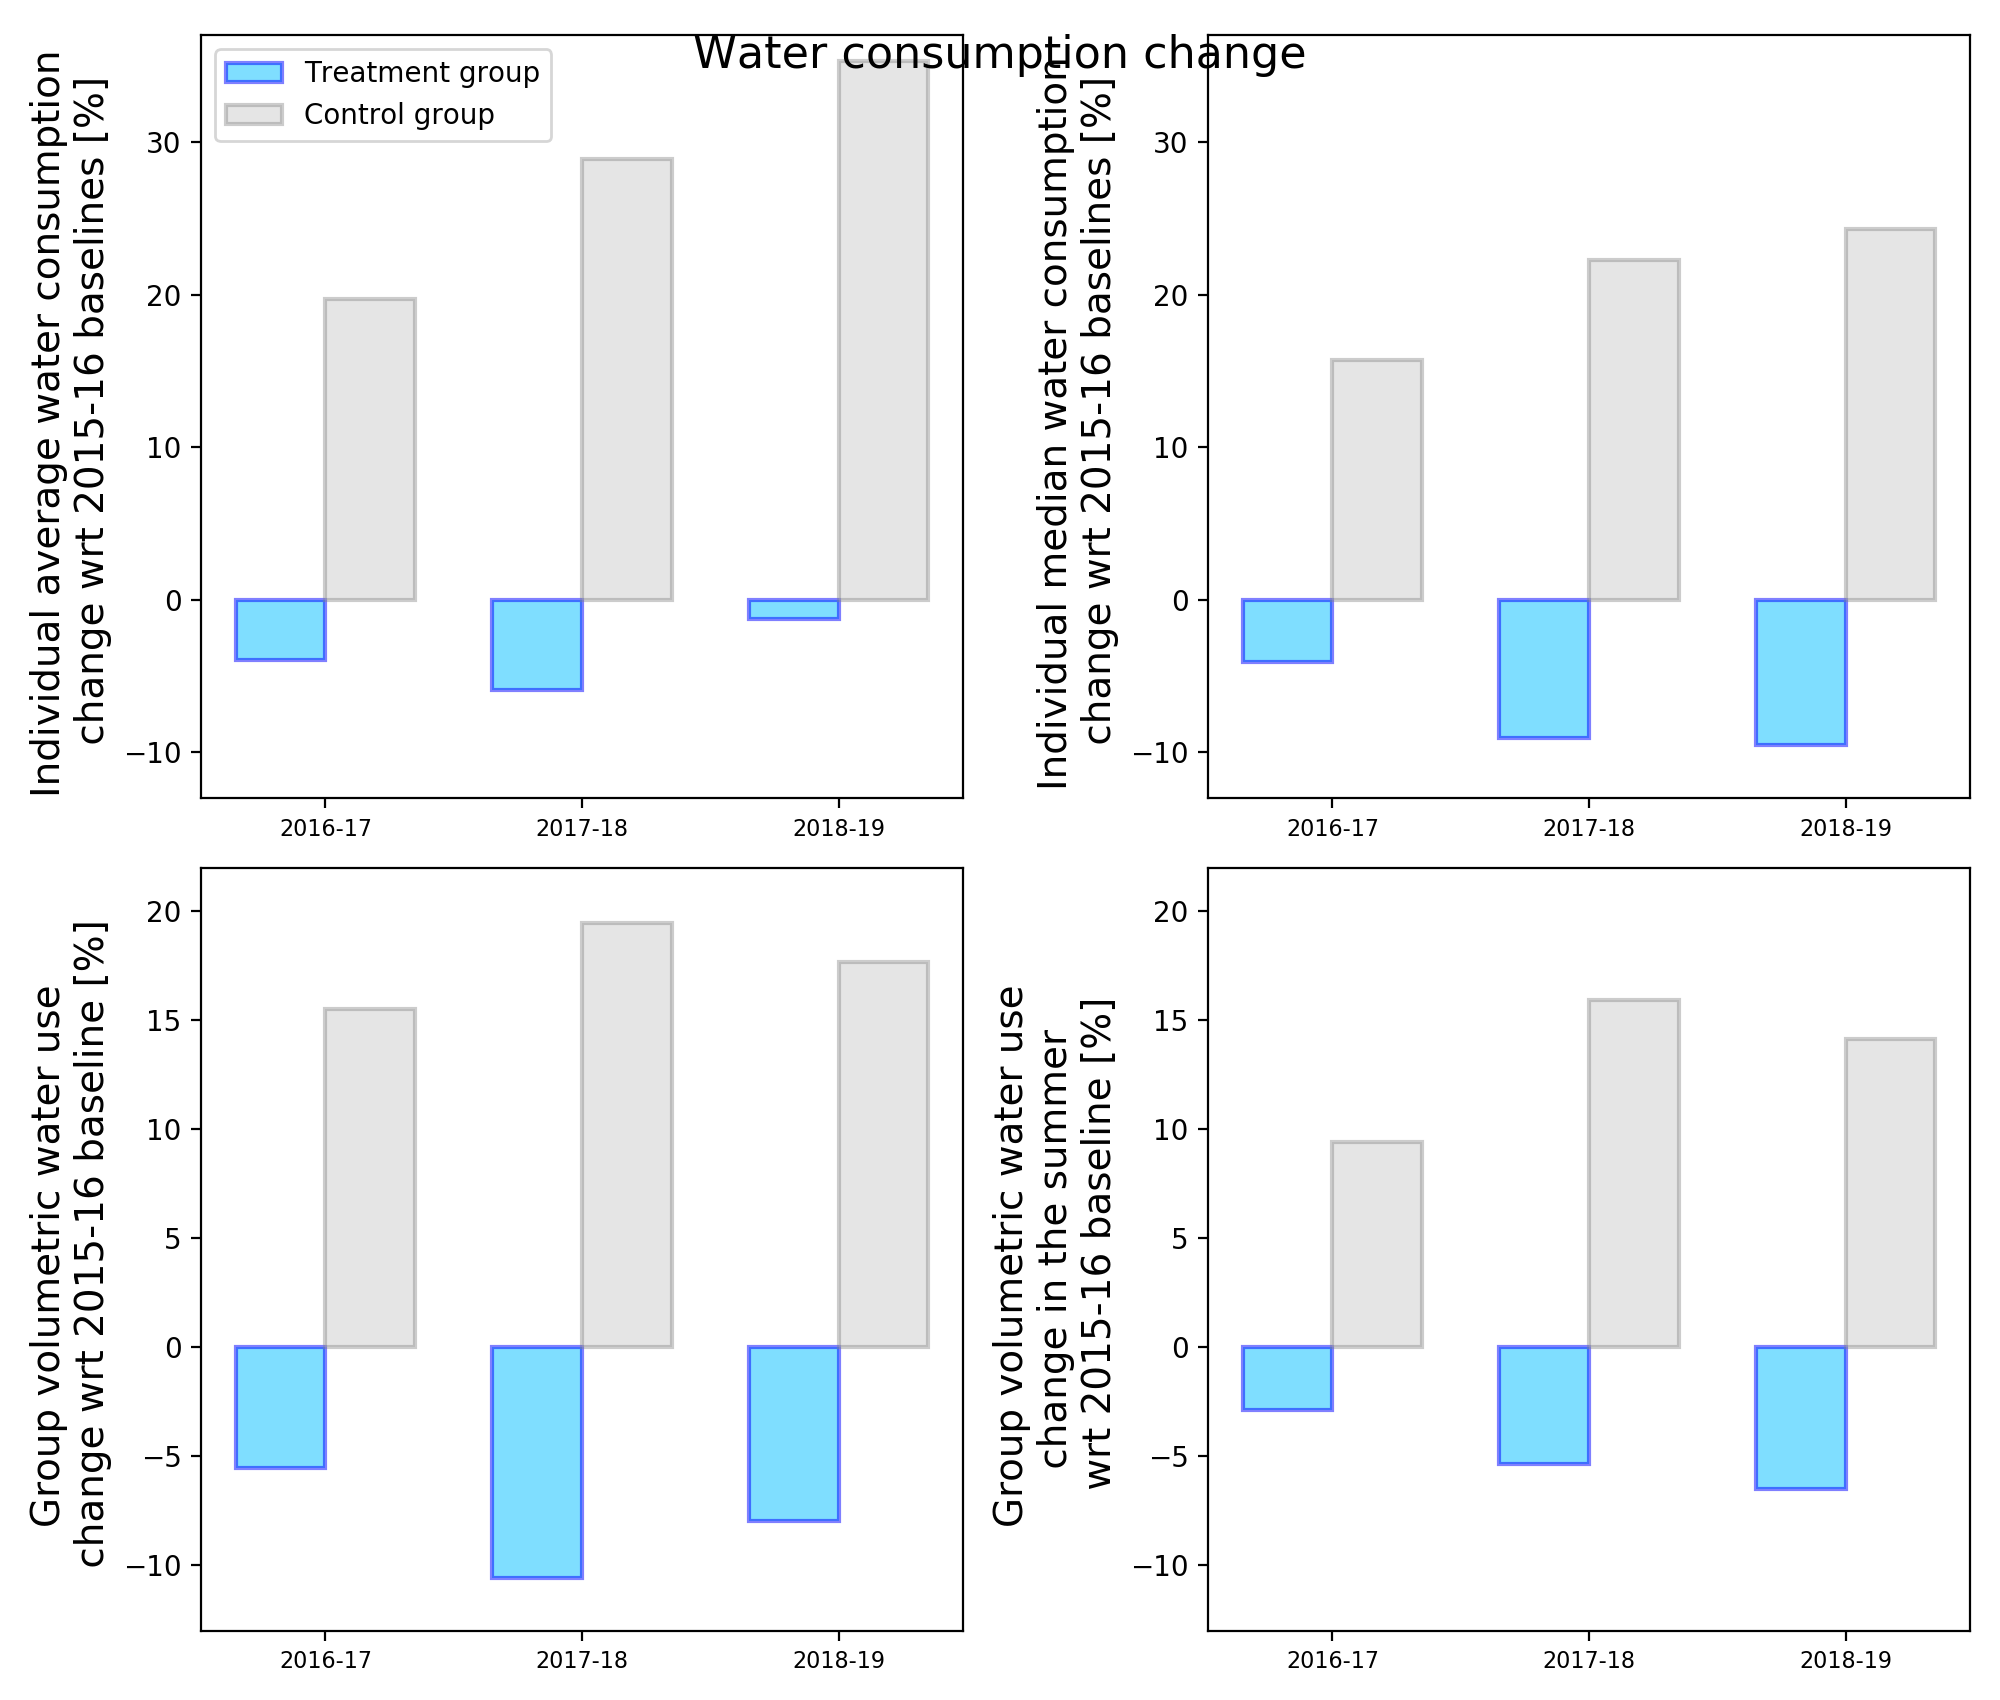

In [39]:
# ::: Water use change 
labels = ['2016-17','2017-18','2018-19']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

plt.rcParams['figure.figsize'] = [10,8.5]
fig, ax = plt.subplots(2,2)


# Average Percentage water use change
rects1 = ax[0,0].bar(x - width/2, avg_percC_tg, width, label='Treatment group',color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[0,0].bar(x + width/2, avg_percC_cg, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0,0].set_ylabel('Individual average water consumption \n change wrt 2015-16 baselines [%]',fontsize=14)
ax[0,0].set_xticks(x)
ax[0,0].set_xticklabels(labels, fontsize=8)
ax[0,0].legend()
ax[0,0].set_ylim([-13, 37])


fig.tight_layout()
plt.show()


# Median Percentage water use change
rects1 = ax[0,1].bar(x - width/2, m_percC_tg, width, label='SmartH2O users',color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[0,1].bar(x + width/2, m_percC_cg, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0,1].set_ylabel('Individual median water consumption \n change wrt 2015-16 baselines [%]',fontsize=14)
ax[0,1].set_xticks(x)
ax[0,1].set_xticklabels(labels, fontsize=8)
ax[0,1].set_ylim([-13, 37])



fig.tight_layout()
plt.show()

# Volumetric water use change
rects1 = ax[1,0].bar(x - width/2, avg_volC_tg, width, label='Treatment group', color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[1,0].bar(x + width/2, avg_volC_cg, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1,0].set_ylabel('Group volumetric water use \n change wrt 2015-16 baseline [%]',  fontsize=14)
ax[1,0].set_xticks(x)
ax[1,0].set_xticklabels(labels, fontsize=8)
ax[1,0].set_ylim([-13, 22])

#ax[1].legend()
fig.tight_layout()
plt.show()


# Volumetric water use change - SUMMER
rects1 = ax[1,1].bar(x - width/2, avg_volC_tg_summer, width, label='Treatment group', color = 'deepskyblue', alpha=0.5, edgecolor = 'blue', linewidth=1.5)
rects2 = ax[1,1].bar(x + width/2, avg_volC_cg_summer, width, label='Control group',color = 'silver', alpha=0.4, edgecolor = 'grey', linewidth=1.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1,1].set_ylabel('Group volumetric water use \n change in the summer \n wrt 2015-16 baseline [%]',  fontsize=14)
ax[1,1].set_xticks(x)
ax[1,1].set_xticklabels(labels, fontsize=8)
ax[1,1].set_ylim([-13, 22])


#ax[1].legend()
fig.tight_layout()
plt.show()

fig.suptitle('Water consumption change', fontsize=16)
fig.savefig("PaperFigs/F1_waterUseChange_v0.2.pdf", bbox_inches='tight')



<IPython.core.display.Javascript object>


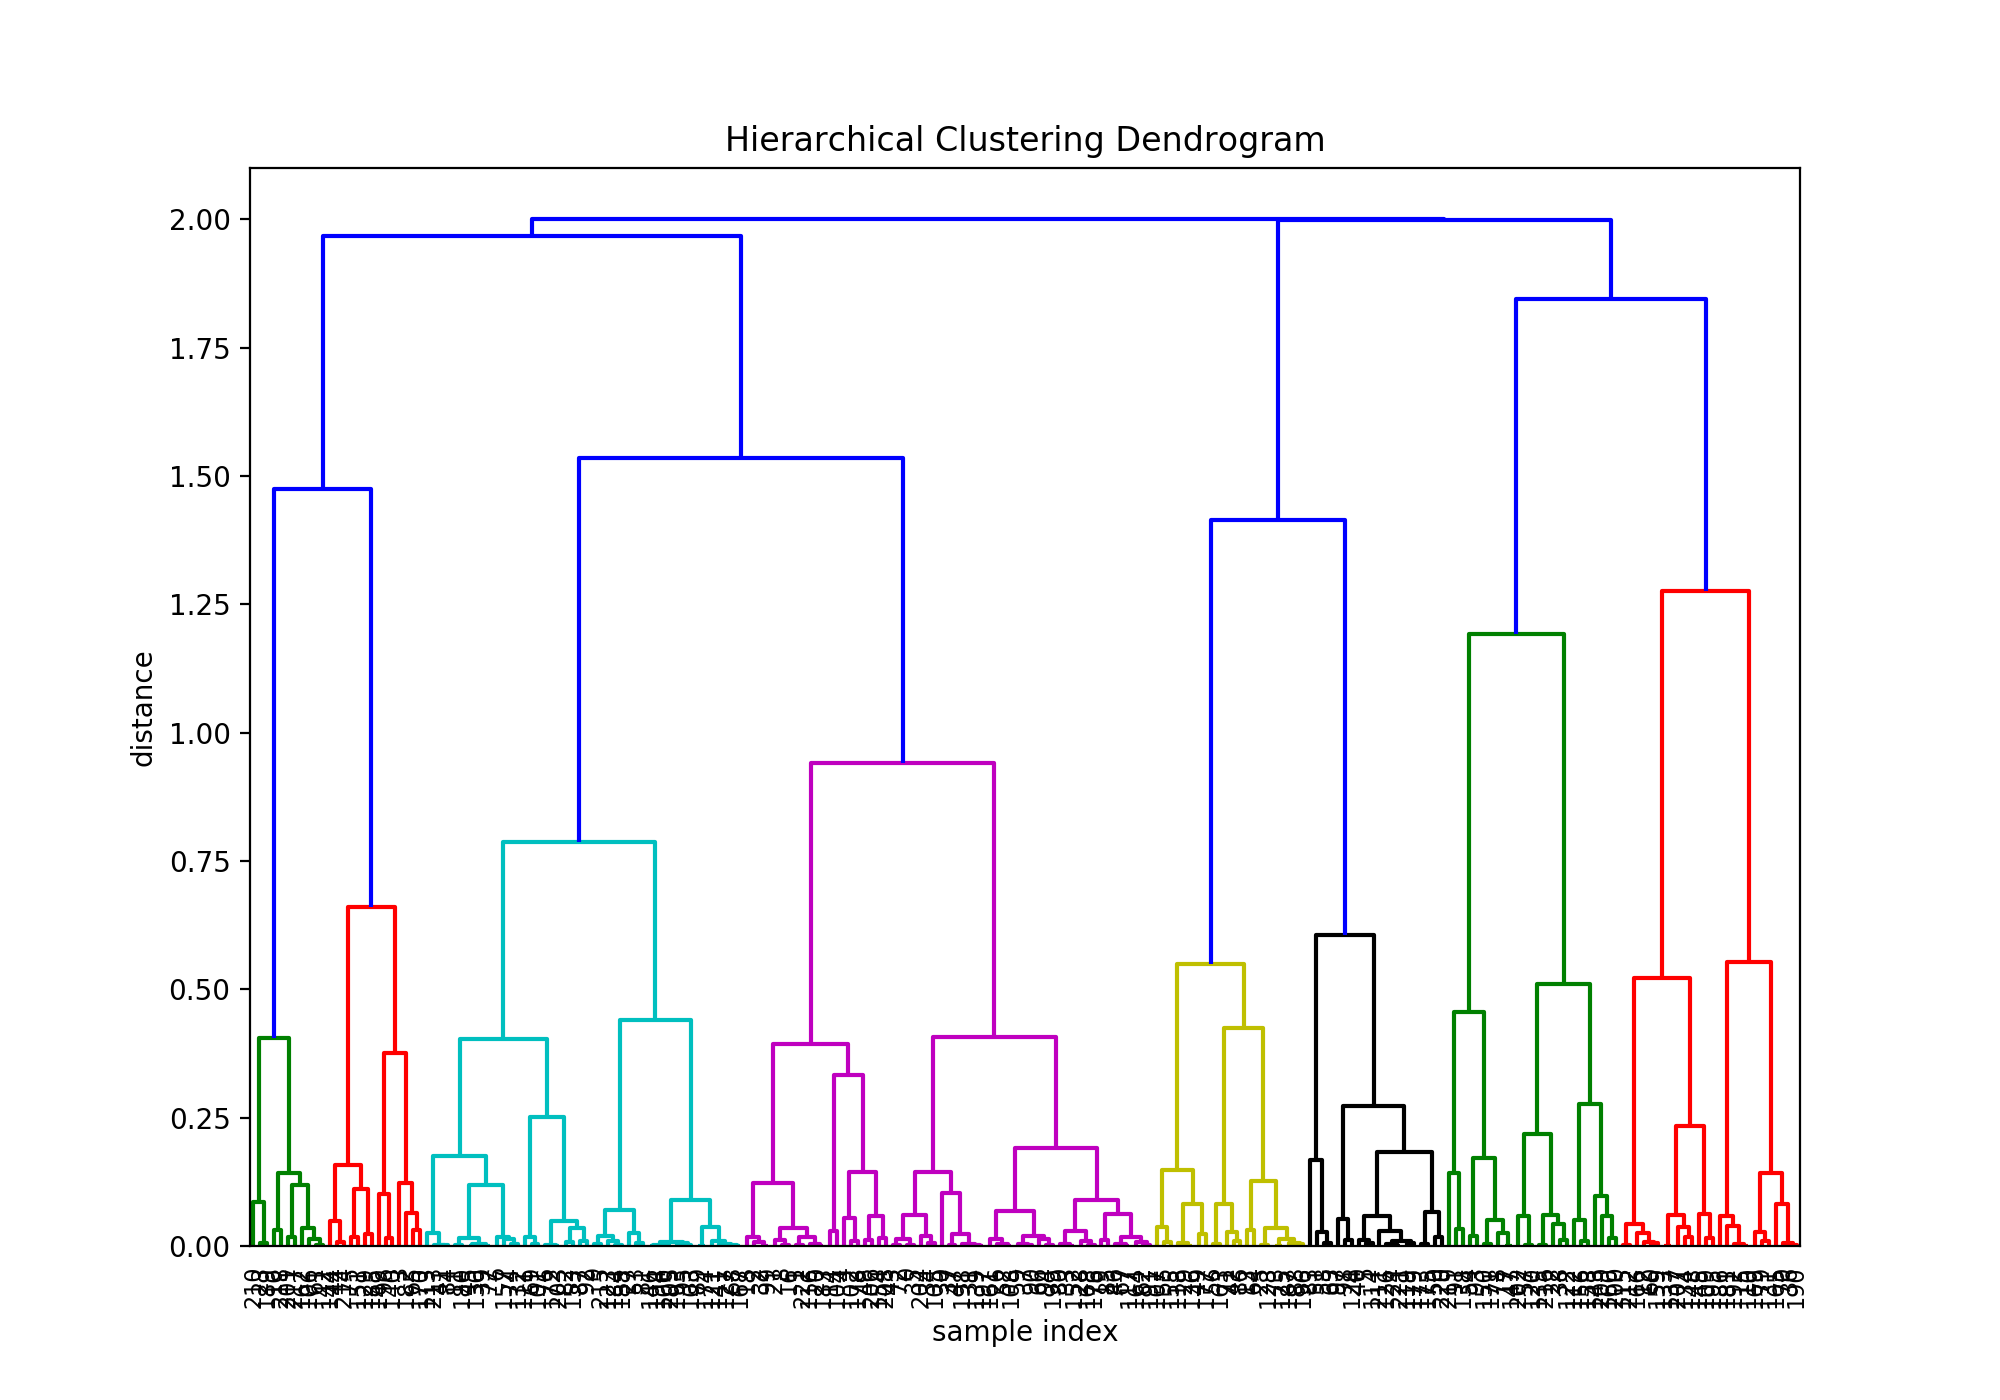

In [36]:
# Clustering patterns
import scipy.cluster.hierarchy as spc
import matplotlib.colors as mcolors
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

df = allData_tg[['avg_baseline', 'avg_1617', 'avg_1718', 'avg_1819']]
df_norm = df.div(df.sum(axis=1), axis=0) # Normalized dataframe


#df = df.transpose()
#corr = df.corr()
#pdist = spc.distance.pdist(corr)

Z = spc.linkage(df, metric='correlation', method='complete')
# calculate full dendrogram
plt.rcParams['figure.figsize'] = [7, 7]
plt.figure(figsize=(10, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
spc.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

<IPython.core.display.Javascript object>


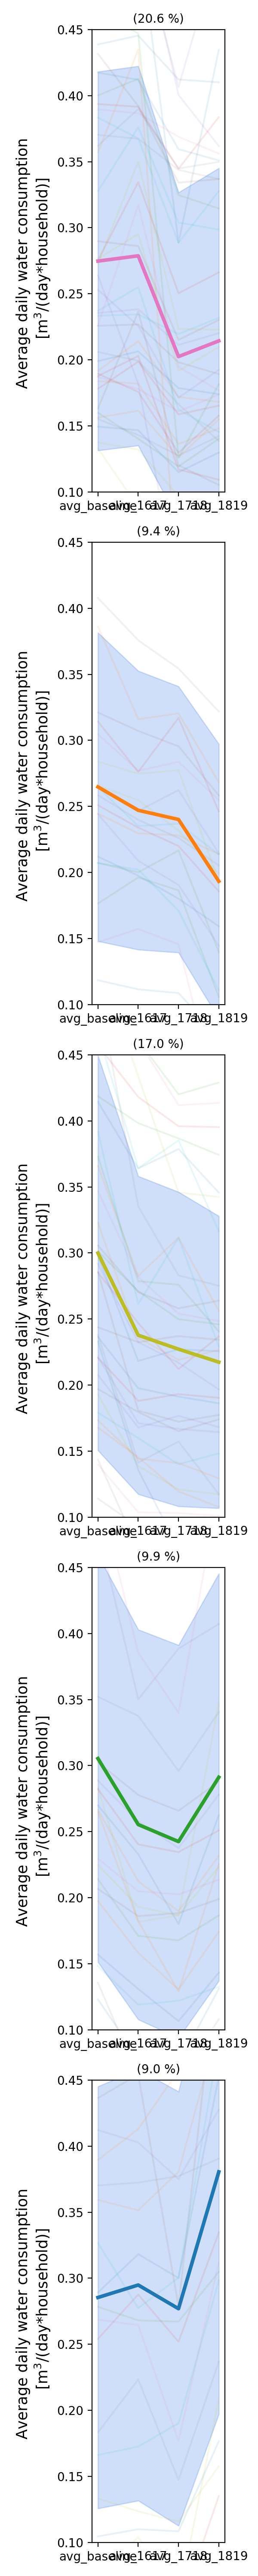

In [38]:
idx = spc.fcluster(Z, 0.85, 'distance')
#df = df.div(df.sum(axis=1), axis=0) # Normalized dataframe

df = df.transpose()
# Representing clustered patterns
plt.rcParams['figure.figsize'] = [3,30]
fig, ax = plt.subplots(5,1)
pC = 0
for i in range(np.max(idx)):
    if i>1 and i<7:
        toPlot = df.iloc[:,idx==i+1]
        ax[pC].plot(toPlot,alpha=0.1)
        toPlotMean = np.mean(toPlot, axis=1)
        line = ax[pC].lines[0] # get the first line, there might be more
        x=line.get_xdata()
        col = ['coral', 'coral', 'y', 'royalblue', 'royalblue']
        ax[pC].fill_between(x,toPlotMean-np.std(toPlot, axis=1), toPlotMean+np.std(toPlot, axis=1), color ='cornflowerblue', alpha = 0.3)
        ax[pC].plot(toPlotMean, linewidth=3)#, c=col[i] )
        ax[pC].set_ylim([0.1, 0.45])
        ax[pC].tick_params(axis='x', rotation=0)
        ax[pC].set_title('(%.1f %%)' % (sum(idx==i+1)/len(idx)*100), fontsize=10)
        ax[pC].set_ylabel('Average daily water consumption \n [m$^3$/(day*household)]', fontsize=12.5)
        pC = pC+1
#fig.savefig("PaperFigs/F4_segments_v0.2.pdf", bbox_inches='tight')


fig.tight_layout()

allData_tg['ClusterIDX'] = idx

# Logistic regression

In [1]:
# Regression tree - Water Savers vs Rebound/Increase
in_file = 'XY.csv'
XY = pd.read_csv(in_file, sep=',', header=None)
XY = XY.dropna()
Y = XY.iloc[:,-1]

indexNames = XY[ Y == 1].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 2].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 3].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 6].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 7].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 4].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 8].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 9].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 10].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 11].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

       
X = XY.iloc[:,:-1]
X = X[[1,0,2,3,4]]
X[1] = X[1]-1
tempVar = X[1]
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # Normalize features
X[1] = tempVar
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)


#Y[Y == 1] = 0
#Y[Y == 2] = 0
Y[Y == 3] = 1
Y[Y == 4] = 1
Y[Y == 5] = 1
Y[Y == 6] = 0
Y[Y == 7] = 0
#Y[Y == 8] = 0
#Y[Y == 9] = 0
#Y[Y == 10] =0
#Y[Y == 11] = 0

# Decision Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics, svm #Import scikit-learn metrics modu
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold

feature_cols = ['freq','Logins','number_of_events_noPoints','number_of_events_Points', 'importance_y']

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


def score_model(model, X, Y, cv):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=3, random_state=10, shuffle=True)

    smoter = SMOTE(random_state=10, sampling_strategy='auto')
    
    precisionT = []
    recallT = []
    fscoreT = []
    supportT = []
    model_coef = []
    aucT = []
    
    for train_fold_index, val_fold_index in cv.split(X, Y):
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index], Y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index], Y[val_fold_index]

        # Oversample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,y_train_fold)
        # Fit the model on the oversampled training data
        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        model_coef.append(model_obj.coef_)
        
        # Score the model on the (non-oversampled) validation data
        precision, recall, fscore, support = precision_recall_fscore_support(y_val_fold, model_obj.predict(X_val_fold), average = 'weighted')
        auc = roc_auc_score(y_val_fold, model_obj.predict(X_val_fold), average = 'weighted')
        precisionT.append(precision)
        recallT.append(recall)
        fscoreT.append(fscore)
        aucT.append(auc)
        #supportT.append(support)
    return model_coef, precisionT, recallT, fscoreT, aucT

# Logistic classification with oversampling and cross-validation
clf = LogisticRegression(random_state=10, multi_class='auto', penalty = 'l2', class_weight = 'balanced')
kf = KFold(n_splits=5, random_state=10, shuffle=True)
model_coef_sri, precision_sri, recall_sri, fscore_sri, roc_auc_sri = score_model(clf, X, Y, kf)

meanCoeff_sri = np.mean(np.array(model_coef_sri), axis = 0)
stdCoeff_sri = np.std(np.array(model_coef_sri), axis = 0)
print(meanCoeff_sri)
print(stdCoeff_sri)
print(np.mean(fscore_sri))

NameError: name 'pd' is not defined

In [316]:
# Regression tree - Water Savers vs Rebound/Increase
in_file = 'XY.csv'
XY = pd.read_csv(in_file, sep=',', header=None)
XY = XY.dropna()
Y = XY.iloc[:,-1]

indexNames = XY[ Y == 1].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 2].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 3].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 6].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 7].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 4].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 8].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 9].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 10].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 11].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

       
X = XY.iloc[:,:-1]
X = X[[1,0,2,3,4]]
X[1] = X[1]-1
tempVar = X[1]
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # Normalize features
X[1] = tempVar
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)


#Y[Y == 1] = 0
#Y[Y == 2] = 0
#Y[Y == 3] = 1
Y[Y == 4] = 1
Y[Y == 5] = 0
#Y[Y == 6] = 0
#Y[Y == 7] = 0
#Y[Y == 8] = 0
#Y[Y == 9] = 0
#Y[Y == 10] =0
#Y[Y == 11] = 0

# Decision Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics, svm #Import scikit-learn metrics modu
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold

feature_cols = ['freq','Logins','number_of_events_noPoints','number_of_events_Points', 'importance_y']

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


def score_model(model, X, Y, cv):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=3, random_state=10, shuffle=True)

    smoter = SMOTE(random_state=10, sampling_strategy='auto')
    
    precisionT = []
    recallT = []
    fscoreT = []
    supportT = []
    model_coef = []
    aucT = []
    
    for train_fold_index, val_fold_index in cv.split(X, Y):
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index], Y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index], Y[val_fold_index]

        # Oversample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,y_train_fold)
        # Fit the model on the oversampled training data
        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        model_coef.append(model_obj.coef_)
        
        # Score the model on the (non-oversampled) validation data
        precision, recall, fscore, support = precision_recall_fscore_support(y_val_fold, model_obj.predict(X_val_fold), average = 'weighted')
        auc = roc_auc_score(y_val_fold, model_obj.predict(X_val_fold), average = 'weighted')
        precisionT.append(precision)
        recallT.append(recall)
        fscoreT.append(fscore)
        aucT.append(auc)
        #supportT.append(support)
    return model_coef, precisionT, recallT, fscoreT, aucT

# Logistic classification with oversampling and cross-validation
clf = LogisticRegression(random_state=10, multi_class='auto', penalty = 'l2', class_weight = 'balanced')
kf = KFold(n_splits=5, random_state=10, shuffle=True)
model_coef_s, precision_s, recall_s, fscore_s, roc_auc_s = score_model(clf, X, Y, kf)

meanCoeff_s = np.mean(np.array(model_coef_s), axis = 0)
stdCoeff_s = np.std(np.array(model_coef_s), axis = 0)
print(meanCoeff_s)
print(stdCoeff_s)
print(np.mean(fscore_s))

[[ 0.46531818 -0.08698147  0.72378773 -0.47580966  0.55500036]]
[[0.46701099 0.31825748 0.11445677 0.32599784 0.23319228]]
0.5507248307248307


In [2]:
# Regression tree - Water Savers vs Rebound/Increase
in_file = 'XY.csv'
XY = pd.read_csv(in_file, sep=',', header=None)
XY = XY.dropna()
Y = XY.iloc[:,-1]

indexNames = XY[ Y == 1].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 2].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 3].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

indexNames = XY[ Y == 6].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 7].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 4].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
'''
indexNames = XY[ Y == 8].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 9].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 10].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)
indexNames = XY[ Y == 11].index
XY.drop(indexNames , inplace=True)
Y.drop(indexNames , inplace=True)

       
X = XY.iloc[:,:-1]
X = X[[1,0,2,3,4]]
X[1] = X[1]-1
tempVar = X[1]
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # Normalize features
X[1] = tempVar
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)


#Y[Y == 1] = 0
#Y[Y == 2] = 0
Y[Y == 3] = 1
Y[Y == 4] = 1
Y[Y == 5] = 1
Y[Y == 6] = 0
#Y[Y == 7] = 0
#Y[Y == 8] = 0
#Y[Y == 9] = 0
#Y[Y == 10] =0
#Y[Y == 11] = 0

# Decision Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics, svm #Import scikit-learn metrics modu
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold

feature_cols = ['freq','Logins','number_of_events_noPoints','number_of_events_Points', 'importance_y']

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


def score_model(model, X, Y, cv):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=3, random_state=10, shuffle=True)

    smoter = SMOTE(random_state=10, sampling_strategy='auto')
    
    precisionT = []
    recallT = []
    fscoreT = []
    supportT = []
    model_coef = []
    aucT = []
    
    for train_fold_index, val_fold_index in cv.split(X, Y):
        # Get the training data
        X_train_fold, y_train_fold = X.iloc[train_fold_index], Y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X.iloc[val_fold_index], Y[val_fold_index]

        # Oversample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,y_train_fold)
        # Fit the model on the oversampled training data
        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
        model_coef.append(model_obj.coef_)
        
        # Score the model on the (non-oversampled) validation data
        precision, recall, fscore, support = precision_recall_fscore_support(y_val_fold, model_obj.predict(X_val_fold), average = 'weighted')
        auc = roc_auc_score(y_val_fold, model_obj.predict(X_val_fold), average = 'weighted')
        precisionT.append(precision)
        recallT.append(recall)
        fscoreT.append(fscore)
        aucT.append(auc)
        #supportT.append(support)
    return model_coef, precisionT, recallT, fscoreT, aucT

# Logistic classification with oversampling and cross-validation
clf = LogisticRegression(random_state=10, multi_class='auto', penalty = 'l2', class_weight = 'balanced')
kf = KFold(n_splits=5, random_state=10, shuffle=True)
model_coef_rs, precision_rs, recall_rs, fscore_rs, roc_auc_rs = score_model(clf, X, Y, kf)

meanCoeff_rs = np.mean(np.array(model_coef_rs), axis = 0)
stdCoeff_rs = np.std(np.array(model_coef_rs), axis = 0)
print(meanCoeff_rs)
print(stdCoeff_rs)
print(np.mean(fscore_rs))

NameError: name 'pd' is not defined

<IPython.core.display.Javascript object>


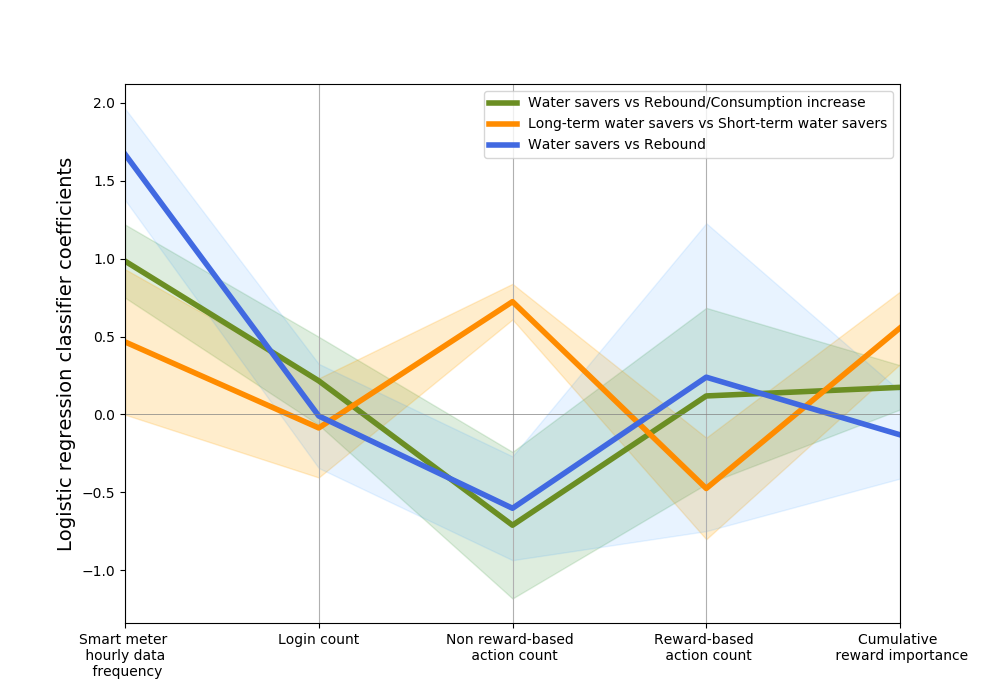

In [335]:
# Plotting figure
plt.rcParams['figure.figsize'] = [10, 7]
fig=plt.figure()# Grouped boxplot
ax = fig.gca()
plt.plot(meanCoeff_sri[0], lineWidth = 4, color = 'olivedrab')
ax.fill_between([0,1,2,3,4],meanCoeff_sri[0]-stdCoeff_sri[0], meanCoeff_sri[0]+stdCoeff_sri[0], color ='forestgreen', alpha = 0.15)
plt.plot(meanCoeff_s[0], lineWidth = 4, color = 'darkorange')
ax.fill_between([0,1,2,3,4],meanCoeff_s[0]-stdCoeff_s[0], meanCoeff_s[0]+stdCoeff_s[0], color ='orange', alpha = 0.2)
plt.plot(meanCoeff_rs[0], lineWidth = 4, color = 'royalblue')
ax.fill_between([0,1,2,3,4],meanCoeff_rs[0]-stdCoeff_rs[0], meanCoeff_rs[0]+stdCoeff_rs[0], color ='dodgerblue', alpha = 0.1)

plt.axhline(y=0, color='gray', lineWidth = 0.5)#, linestyle=':')


ax.legend(['Water savers vs Rebound/Consumption increase','Long-term water savers vs Short-term water savers', 'Water savers vs Rebound'])
ax.set_xlim([0, 4])
#ax.set_ylim([-1.3, 1.3])
ax.set_ylabel('Logistic regression classifier coefficients', fontsize = 14)


major_ticks = np.arange(0, 5, 1)
ax.set_xticks(major_ticks)
ax.xaxis.grid(which='major')
ax.tick_params(axis='x', rotation=0)
ax.set_xticklabels(['Smart meter \n hourly data \n frequency', 'Login count', 'Non rewarded \n action count', 'Rewarded \n action count', 'Cumulative \n reward importance'] )

plt.show()
fig.savefig("PaperFigs/F4_LogReg_R2.pdf", bbox_inches='tight')

